<a href="https://colab.research.google.com/github/mickey2798/Simpl---Data-Science-Assignment/blob/master/Simpl_Data_Science_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing all the necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn import metrics

from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, recall_score, precision_score,make_scorer,classification_report,roc_curve
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
##Mounting the Google Drive to load the Data.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1VDz4SEhPl4O2VgbIMg3IDUnh0_4_u2oS/view?usp=sharing'
id = link.split('/')[5]
print (id)

1VDz4SEhPl4O2VgbIMg3IDUnh0_4_u2oS


In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('simpl_payments_bank_digicard_v1.0.csv') 

In [ ]:
df = pd.read_csv("simpl_payments_bank_digicard_v1.0.csv")
df.head()

,user_id,gender,date_of_birth,workclass,education_level,education_num,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,approved,address,email,inquiry_purpose_code,institute_type,account_type,asset_class_cd,asset_code,portfolio_type
0,307c73a3-0c67-43b5-b0d1-62ad5f00b52a,Female,1987-01-03,Private,11th,7.0,Never-married,Sales,Unmarried,0.0,0.0,17.0,0,"45424 Norris Common Apt. 390\r\nNorth Mike, AR...",vasquezleah@yahoo.com,7.0,PVT,5,NaN,1.0,R
1,519481f1-604d-48b6-aa47-4123a982431a,Male,1970-01-07,Self-emp-not-inc,Some-college,10.0,Married-civ-spouse,Craft-repair,Husband,0.0,0.0,48.0,0,"5022 Rebecca Haven Apt. 258\r\nThompsonfurt, C...",johnsontrevor@hotmail.com,13.0,NBF,5,NaN,1.0,R
2,f66fe2c6-53e3-46ce-8321-e530b4af1ace,Male,1973-01-06,Private,HS-grad,9.0,Divorced,Sales,Not-in-family,0.0,0.0,50.0,0,"8780 Brown Loaf Apt. 099\r\nNorth David, NJ 56510",morganemily@gmail.com,13.0,NBF,5,NaN,1.0,R
3,91360ed7-72d1-4f6e-b492-d71ef4480061,Female,2001-12-30,Private,11th,7.0,Never-married,Sales,Own-child,0.0,0.0,15.0,0,721 Jackson Extensions Suite 995\r\nNew Tarasi...,agarcia@hotmail.com,13.0,NBF,5,NaN,1.0,R
4,0e1977f3-3bef-4283-8d0a-d60b0f6ff480,Male,1986-01-03,Private,Some-college,10.0,Married-civ-spouse,Handlers-cleaners,Husband,0.0,0.0,50.0,0,"935 Burch Divide\r\nLake Bobbyfurt, VT 14128",shermanmeredith@gmail.com,13.0,PVT,47,S,1.0,I


In [ ]:
##Knowing the shape of the data ==> we have 45222 rows and 21 features
df.shape

(45222, 21)

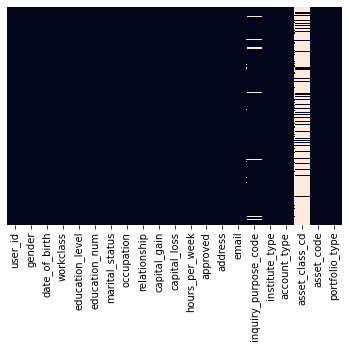

In [ ]:
#Checking nulls using heatmaps
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

In [ ]:
##Checking how many nulls do we have in our DataSet.
nulls = df.isnull().sum(axis=0).to_frame()
for index, row in nulls.iterrows():
  print(f"{index} : {row[0]}")


user_id : 0
gender : 0
date_of_birth : 0
workclass : 0
education_level : 0
education_num : 0
marital_status : 0
occupation : 0
relationship : 0
capital_gain : 0
capital_loss : 0
hours_per_week : 0
approved : 0
address : 0
email : 0
inquiry_purpose_code : 1291
institute_type : 0
account_type : 0
asset_class_cd : 35730
asset_code : 82
portfolio_type : 6


### Clearly, we can see that out of 21 features we have got 4 features that are having null values.  inquiry_purpose_code, asset_class_cd, portfolio_type, asset_code. We can actually drop asset_class_cd directly because we can see 35730 are nulls which is greater that 50% of the total.



In [ ]:
df.drop(['asset_class_cd'], axis=1, inplace=True)

In [ ]:
df.shape

(45222, 20)

In [ ]:
##Filing the missing values 
df['inquiry_purpose_code']=df['inquiry_purpose_code']\
.fillna(df['inquiry_purpose_code'].mode()[0])

In [ ]:
##Filing the missing values 
df['asset_code']=df['asset_code']\
.fillna(df['asset_code'].mode()[0])

In [ ]:
##Filing the missing values 
df['portfolio_type']=df['portfolio_type']\
.fillna(df['portfolio_type'].mode()[0])

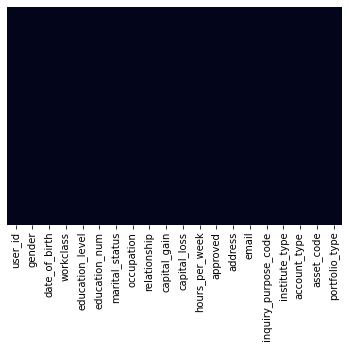

In [ ]:
#Checking nulls using heatmaps
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

In [ ]:
##Checking how many nulls do we have in our DataSet.
nulls = df.isnull().sum(axis=0).to_frame()
for index, row in nulls.iterrows():
  print(f"{index} : {row[0]}")

user_id : 0
gender : 0
date_of_birth : 0
workclass : 0
education_level : 0
education_num : 0
marital_status : 0
occupation : 0
relationship : 0
capital_gain : 0
capital_loss : 0
hours_per_week : 0
approved : 0
address : 0
email : 0
inquiry_purpose_code : 0
institute_type : 0
account_type : 0
asset_code : 0
portfolio_type : 0


### Doing Some Feature Engineering

In [ ]:
# DOB is a date variable has to be converted to date
import datetime as dt

In [ ]:
df['dob']  = [dt.datetime.strptime(d, "%Y-%m-%d") for d in df["date_of_birth"]]

In [ ]:
# Calculate Age from DOB
now = pd.Timestamp('now')
df['dob'] = df['dob'].where(df['dob'] < now, df['dob'] -  np.timedelta64(100, 'Y'))
df['age'] = (now - df['dob']).astype('<m8[Y]')

In [ ]:
df.drop(['date_of_birth'], axis=1, inplace=True)
df.drop(['dob'], axis=1, inplace=True)

In [ ]:
df.head()

,user_id,gender,workclass,education_level,education_num,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,approved,address,email,inquiry_purpose_code,institute_type,account_type,asset_code,portfolio_type,age
0,307c73a3-0c67-43b5-b0d1-62ad5f00b52a,Female,Private,11th,7.0,Never-married,Sales,Unmarried,0.0,0.0,17.0,0,"45424 Norris Common Apt. 390\r\nNorth Mike, AR...",vasquezleah@yahoo.com,7.0,PVT,5,1.0,R,34.0
1,519481f1-604d-48b6-aa47-4123a982431a,Male,Self-emp-not-inc,Some-college,10.0,Married-civ-spouse,Craft-repair,Husband,0.0,0.0,48.0,0,"5022 Rebecca Haven Apt. 258\r\nThompsonfurt, C...",johnsontrevor@hotmail.com,13.0,NBF,5,1.0,R,51.0
2,f66fe2c6-53e3-46ce-8321-e530b4af1ace,Male,Private,HS-grad,9.0,Divorced,Sales,Not-in-family,0.0,0.0,50.0,0,"8780 Brown Loaf Apt. 099\r\nNorth David, NJ 56510",morganemily@gmail.com,13.0,NBF,5,1.0,R,48.0
3,91360ed7-72d1-4f6e-b492-d71ef4480061,Female,Private,11th,7.0,Never-married,Sales,Own-child,0.0,0.0,15.0,0,721 Jackson Extensions Suite 995\r\nNew Tarasi...,agarcia@hotmail.com,13.0,NBF,5,1.0,R,19.0
4,0e1977f3-3bef-4283-8d0a-d60b0f6ff480,Male,Private,Some-college,10.0,Married-civ-spouse,Handlers-cleaners,Husband,0.0,0.0,50.0,0,"935 Burch Divide\r\nLake Bobbyfurt, VT 14128",shermanmeredith@gmail.com,13.0,PVT,47,1.0,I,35.0


In [ ]:
# extracting the list of categorical & Numerical variables 
cat_var = list(df.select_dtypes(include='object').columns)
num_var = list(df.select_dtypes(exclude='object').columns)

## Categorical feature exploration

In [ ]:
for col in cat_var:
    print("# Unique values in the feature", col, ":", df[col].nunique())

# Unique values in the feature user_id : 45222
# Unique values in the feature gender : 2
# Unique values in the feature workclass : 7
# Unique values in the feature education_level : 16
# Unique values in the feature marital_status : 7
# Unique values in the feature occupation : 14
# Unique values in the feature relationship : 6
# Unique values in the feature address : 45222
# Unique values in the feature email : 44300
# Unique values in the feature institute_type : 10
# Unique values in the feature portfolio_type : 4


In [ ]:
def univarplots(dat, col):
    print("Univariate plot for ",col)
    plt.figure(figsize=(15, 5))
    sns.countplot(x=col, data=dat)
    plt.show()

Univariate plot for  user_id


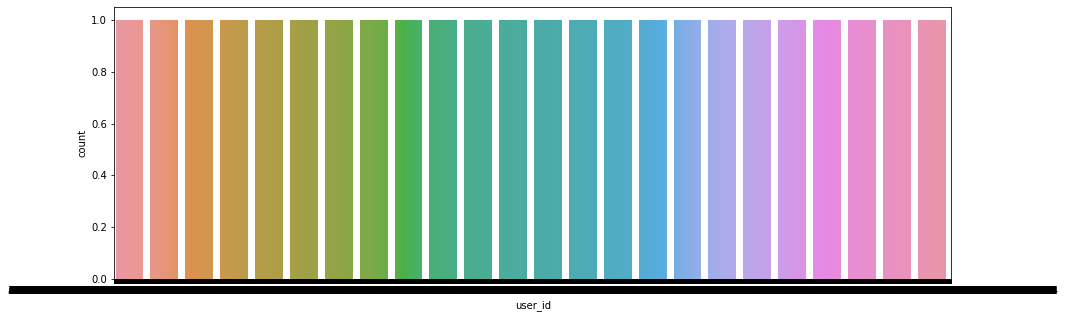

Univariate plot for  gender


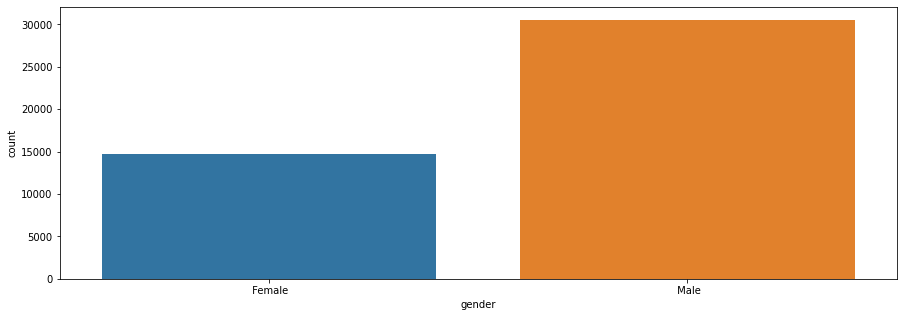

Univariate plot for  workclass


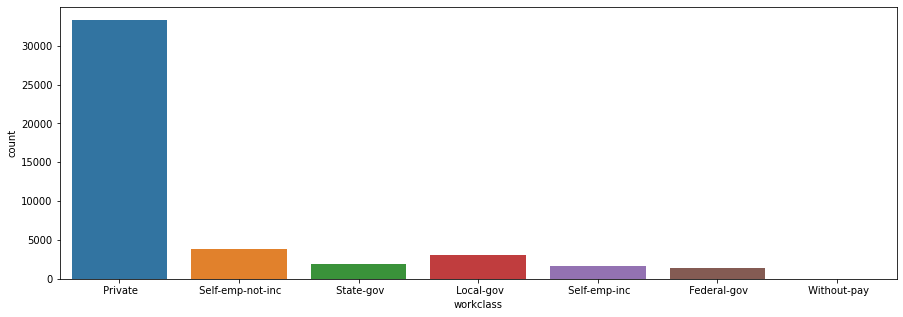

Univariate plot for  education_level


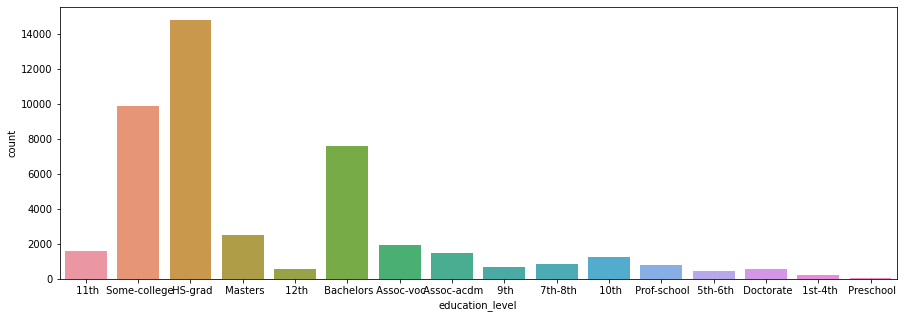

Univariate plot for  marital_status


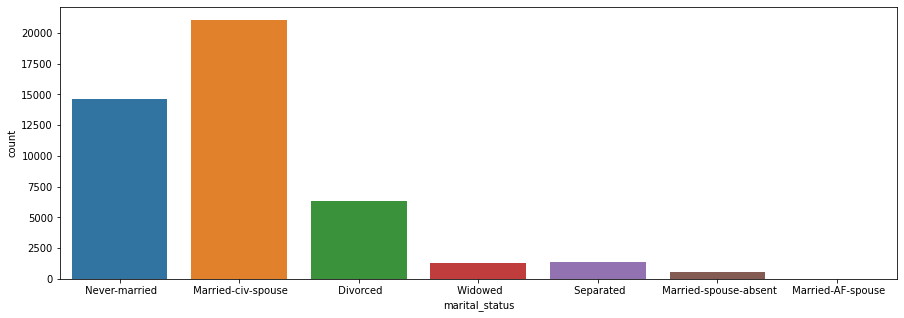

Univariate plot for  occupation


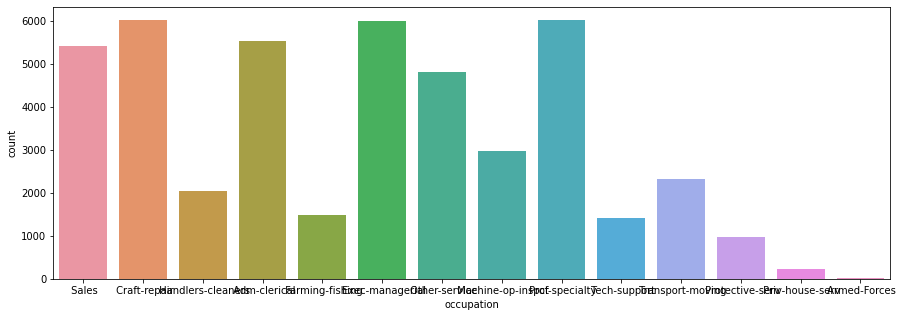

Univariate plot for  relationship


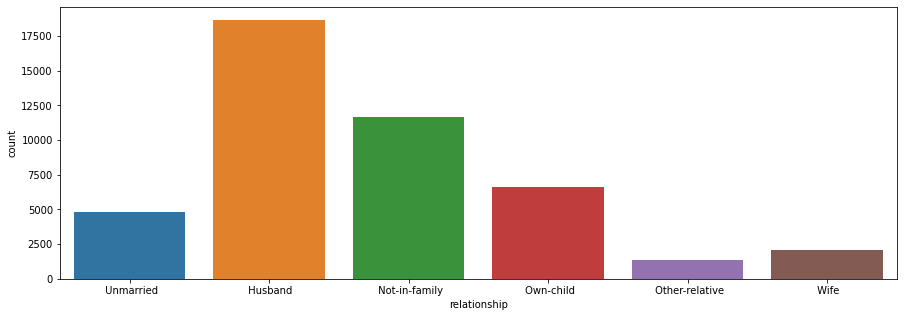

Univariate plot for  institute_type


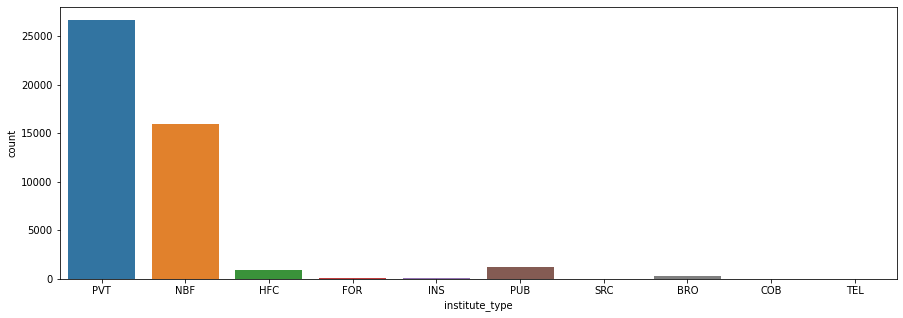

Univariate plot for  portfolio_type


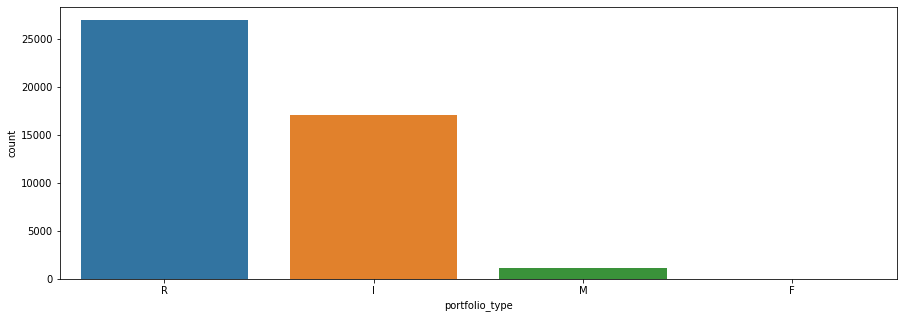

In [ ]:
# Univariate Plots
for col in cat_var:
    if col not in ['address', 'email','domain','website','zip']:
        univarplots(df, col)

In [ ]:
num_var

['education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'approved',
 'inquiry_purpose_code',
 'account_type',
 'asset_code',
 'age']

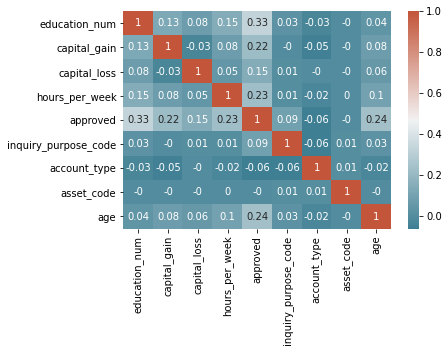

In [ ]:
# analyzing the correlation between the numeric variables
df_num = df[num_var]
corr = df_num.corr()
sns.heatmap(np.round(corr,2), 
            xticklabels=corr.columns,
            yticklabels=corr.columns, 
            annot=True,
            cmap=sns.diverging_palette(220, 20, as_cmap=True)
           )

In [ ]:
df.drop(['address'], axis=1, inplace=True)
df.drop(['email'], axis=1, inplace=True)
df.drop(['user_id'], axis=1, inplace=True)

In [ ]:
cat_var = list(df.select_dtypes(include='object').columns)

In [ ]:
def one_hot_multicols(multcolumns):
    df_final=df
    i=0
    for fields in multcolumns:
        
        print(fields)
        df1=pd.get_dummies(df[fields],drop_first=True)
        
        df.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:
            
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1
       
        
    df_final=pd.concat([df,df_final],axis=1)
        
    return df_final

In [ ]:
final_df = df

In [ ]:
final_df = one_hot_multicols(cat_var)

gender
workclass
education_level
marital_status
occupation
relationship
institute_type
portfolio_type


In [ ]:
final_df.shape

(45222, 67)

In [ ]:
final_df.head()

,education_num,capital_gain,capital_loss,hours_per_week,approved,inquiry_purpose_code,account_type,asset_code,age,Male,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Not-in-family,Other-relative,Own-child,Unmarried,Wife,COB,FOR,HFC,INS,NBF,PUB,PVT,SRC,TEL,I,M,R
0,7.0,0.0,0.0,17.0,0,7.0,5,1.0,34.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,10.0,0.0,0.0,48.0,0,13.0,5,1.0,51.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,9.0,0.0,0.0,50.0,0,13.0,5,1.0,48.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,7.0,0.0,0.0,15.0,0,13.0,5,1.0,19.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,10.0,0.0,0.0,50.0,0,13.0,47,1.0,35.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [ ]:
X=final_df.drop(['approved'], axis=1)
X.head()

,education_num,capital_gain,capital_loss,hours_per_week,inquiry_purpose_code,account_type,asset_code,age,Male,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Not-in-family,Other-relative,Own-child,Unmarried,Wife,COB,FOR,HFC,INS,NBF,PUB,PVT,SRC,TEL,I,M,R
0,7.0,0.0,0.0,17.0,7.0,5,1.0,34.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,10.0,0.0,0.0,48.0,13.0,5,1.0,51.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,9.0,0.0,0.0,50.0,13.0,5,1.0,48.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,7.0,0.0,0.0,15.0,13.0,5,1.0,19.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,10.0,0.0,0.0,50.0,13.0,47,1.0,35.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [ ]:
Y=final_df.approved
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: approved, dtype: int64

In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Accuracy:  0.8532891100055279
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6803
           1       0.74      0.63      0.68      2242

    accuracy                           0.85      9045
   macro avg       0.81      0.78      0.79      9045
weighted avg       0.85      0.85      0.85      9045

AUROC Plot: 0.9047


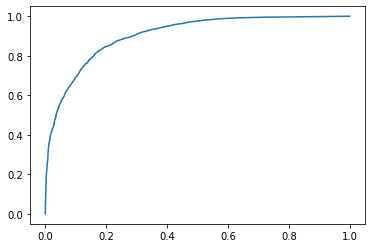

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2019,stratify=Y)
model=RandomForestClassifier(n_estimators=150)

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# AUC ROC CURVE
predictions = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred, average='weighted')

fpr, tpr, threshold = roc_curve(y_test, predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("AUROC Plot:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

Upon investigating why my recall for approved(1) is so low, I got to know that we are facing class imbalance problem.

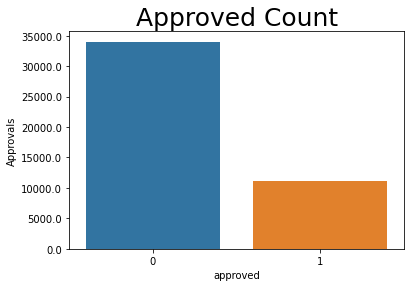

In [ ]:
fig, ax = plt.subplots()
plt.title('Approved Count', fontsize=25)
sns.countplot(df.approved)
ax.set_yticklabels([item for item in ax.get_yticks()])
ax.set_ylabel('Approvals')

plt.show()

### We can see from the plot that, there is a class imbalance problem. We can solve this issue by using SMOTE (Synthetic Minority Oversampling TEchnique)

In [ ]:
TP - 1 FP -1
FN - 8 TN -9

Precision - TP/TP + FP => 1/ (1+1) => 0.5
Recall - TP/(TP+FN) => 1/(1+8) => 1/9
